<h1>Auto grad engine</h1>
<p>This notebook implements an auto gradient engine inspired from tensors in PyTorch. Basic classes like <code>Neuron</code>, <code>Layer</code> and <code>MLP</code> are also implemented using the <code>Value</code> class. At the end, we train a small network on a toy dataset.</p>

In [28]:
import math
import random
from graphviz import Digraph

## Autograd core: Value class

In [33]:
class Value:
    """
    A scalar value that supports automatic differentiation.

    data: the numeric value
    grad: d(output)/d(this value) after calling backward() on the output
    """
    def __init__(self, data, _parent_operands = (), _creator_op = '', label = ''):
        self.data = data
        
        self._parent_operands = set(_parent_operands)
        self._creator_op = _creator_op
        self.label = label
        self.grad = 0.0 # the gradient of end node with respect to this node
        self._backprop = lambda: None
        
    def __repr__(self):
        return f'Value(data = {self.data}, label = {self.label})'

    def __add__(self, operand2):
        operand2  = operand2 if isinstance(operand2, Value) else Value(data = operand2)
        out = Value(data = self.data + operand2.data, _parent_operands = (self, operand2), _creator_op = '+')
        #when a + b is called, it excutes a.__add__(b), a and b are both Value objs
        def _backward():
            self.grad += out.grad * 1
            operand2.grad += out.grad * 1
        out._backprop = _backward        
        return out

    def __radd__(self, operand2):
        return self + operand2

    def __sub__(self, operand2):
        out = self + (-1 * operand2)
        return out

    def __mul__(self, operand2):
        operand2  = operand2 if isinstance(operand2, Value) else Value(data = operand2)
        out = Value(data  = self.data * operand2.data, _parent_operands = (self, operand2), _creator_op = '*')
        #when a * b is called, it excutes a.__mul__(b), a and b are both Value objs
        def _backward():
            self.grad += out.grad * operand2.data
            operand2.grad += out.grad * self.data
        out._backprop = _backward
        return out

    def __rmul__(self, operand2):
        return self * operand2

    def __pow__(self, operand2):
        assert isinstance(operand2, (int, float)) # makes sure that the power is an int or float
        out = Value(data = self.data ** operand2, _parent_operands = (self, ), _creator_op = f'** {operand2}')
        def _backward():
            self.grad += out.grad * (operand2 * (self.data ** (operand2 - 1)))
        out._backprop = _backward
        return out

    def __truediv__(self, operand2): # self/other
        out = self * (operand2 ** -1)        
        return out
        
    def tanh(self):
        x = self.data
        tanhx = (1 - math.exp(-2*x))/(1 + math.exp(-2*x))
        out = Value(data = tanhx, _parent_operands = (self, ), _creator_op = 'tanh' )
        def _backward():            
            self.grad += out.grad * (1 - (tanhx ** 2))
        out._backprop = _backward       
        return out

    def exp(self):
        exp = math.exp(self.data)
        out = Value(data = exp, _parent_operands = (self, ), _creator_op = 'exp')
        def _backward():
            self.grad += out.grad * (out.data)
        out._backprop = _backward
        return out        

    def backward(self):
        markedSet = set()
        ordering = []
        root = self
        def topoSort(root):
            """
            Build a topological ordering of the computation graph ending at root.
            """
            if root in markedSet:
                return
            if not root._parent_operands:
                ordering.append(root)
                markedSet.add(root)
                return 
            for parent in root._parent_operands:
                topoSort(parent)
            markedSet.add(root)
            ordering.append(root)
            return
        topoSort(root)
        self.grad = 1        
        for node in ordering[::-1]:
            node._backprop()
        
        

## Expression graph visualization

In [41]:
def trace(root):
    edges = set()
    nodes = set()
    def dfs(node):
        
        if node not in nodes:
            nodes.add(node)
            for parent in node._parent_operands:
                edge = (parent, node)
                edges.add(edge)
                dfs(parent)
    dfs(root)
    return nodes, edges
    
def draw_graph(root):
    """
    Build and return a Graphviz Digraph visualizing the computation graph
    ending at `root` (a Value).
    """
    dot = Digraph(format='png', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)

    for n in nodes:
        # Node label: value data
        dot.node(name=str(id(n)), label=f" data = {n.data} | label = {n.label} | grad = {n.grad}", shape = 'record')

        # If this Value was created by an operation, draw an op node
        if n._creator_op:
            op_node = str(id(n)) + n._creator_op
            dot.node(op_node, label=n._creator_op, shape='circle')
            dot.edge(op_node, str(id(n)))

            for parent in n._parent_operands:
                dot.edge(str(id(parent)), op_node)

    return dot    

## Neural network abstractions (Neuron, Layer, MLP)

In [42]:
class Neuron:
    """
    A single neuron with a tanh activation.

    inDimension: number of input features.
    """
    def __init__(self, inDimension):
        self.w = [Value(data = random.uniform(-1, 1)) for _ in range(inDimension)]
        self.b = Value(data = random.uniform(-1, 1))
        
    def __call__(self, x):
        # returns w.x + b
        wxi = [w * x for w, x in zip(self.w, x)]
        forwardPassRes = sum(wxi, self.b)        
        return forwardPassRes.tanh()
        
    def getParameters(self):
        return self.w + [self.b]
        
class Layer:
    """
    A fully-connected layer of Neuron objects.
    """
    def __init__(self, inDimension, nNeurons):
        self.layer = [Neuron(inDimension = inDimension) for _ in range(nNeurons)]
        
    def __call__(self, x):
        out = [n(x) for n in self.layer]
        return out[0] if len(out) == 1 else out

    def getParameters(self):
        param = []
        for i in self.layer:
            param.extend(i.getParameters())
        return param
        
class MLP:
    """
    A multi-layer perceptron composed of Layer objects.
    """
    def __init__(self, inDimension, nLayerNeurons):
        layerDimAndSize = [inDimension] + nLayerNeurons
        self.layers = [Layer(layerDimAndSize[i], layerDimAndSize[i + 1]) for i in range(len(nLayerNeurons))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def getParameters(self):
        param = []
        for i in self.layers:
            param.extend(i.getParameters())
        return param

## Example: training an MLP on a toy dataset

In [43]:
def MSE(yExpected, yPred):
    """
    Mean squared error between lists of expected values (floats)
    and predicted Value objects.
    """
    MSE_loss = sum((yp - y) ** 2 for y, yp in zip(yExpected, yPred))
    return MSE_loss

In [44]:
def gradientDescent(lr, epochs, input_x, input_y, mlp):
    """
    Simple training loop using gradient descent on the given MLP.
    """
    for i in range(epochs):
        
        for parameter in mlp.getParameters():
            parameter.grad = 0 #setting the gradients to 0 after each epoch.

        #forward pass
        yPred = [mlp(x) for x in input_x]
        loss = MSE(input_y, yPred)
        

        #backward pass
        loss.backward()

        #updates
        for parameter in mlp.getParameters():
            parameter.data -= lr * (parameter.grad)       
    

### Training example

In [45]:
X = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

yExpected = [1.0, -1.0, -1.0, 1.0]

mlp = MLP(3, [4, 4, 1])





In [46]:
gradientDescent(0.01, 100, X, yExpected, mlp)

In [47]:
yPred = [mlp(x) for x in X]
loss = MSE(yExpected, yPred)
dot = draw_graph(loss)
print(loss)
print(yPred)

Value(data = 0.0335040476223361, label = )
[Value(data = 0.9715593186925536, label = ), Value(data = -0.9323474231748979, label = ), Value(data = -0.8750806455828561, label = ), Value(data = 0.8881364267957078, label = )]


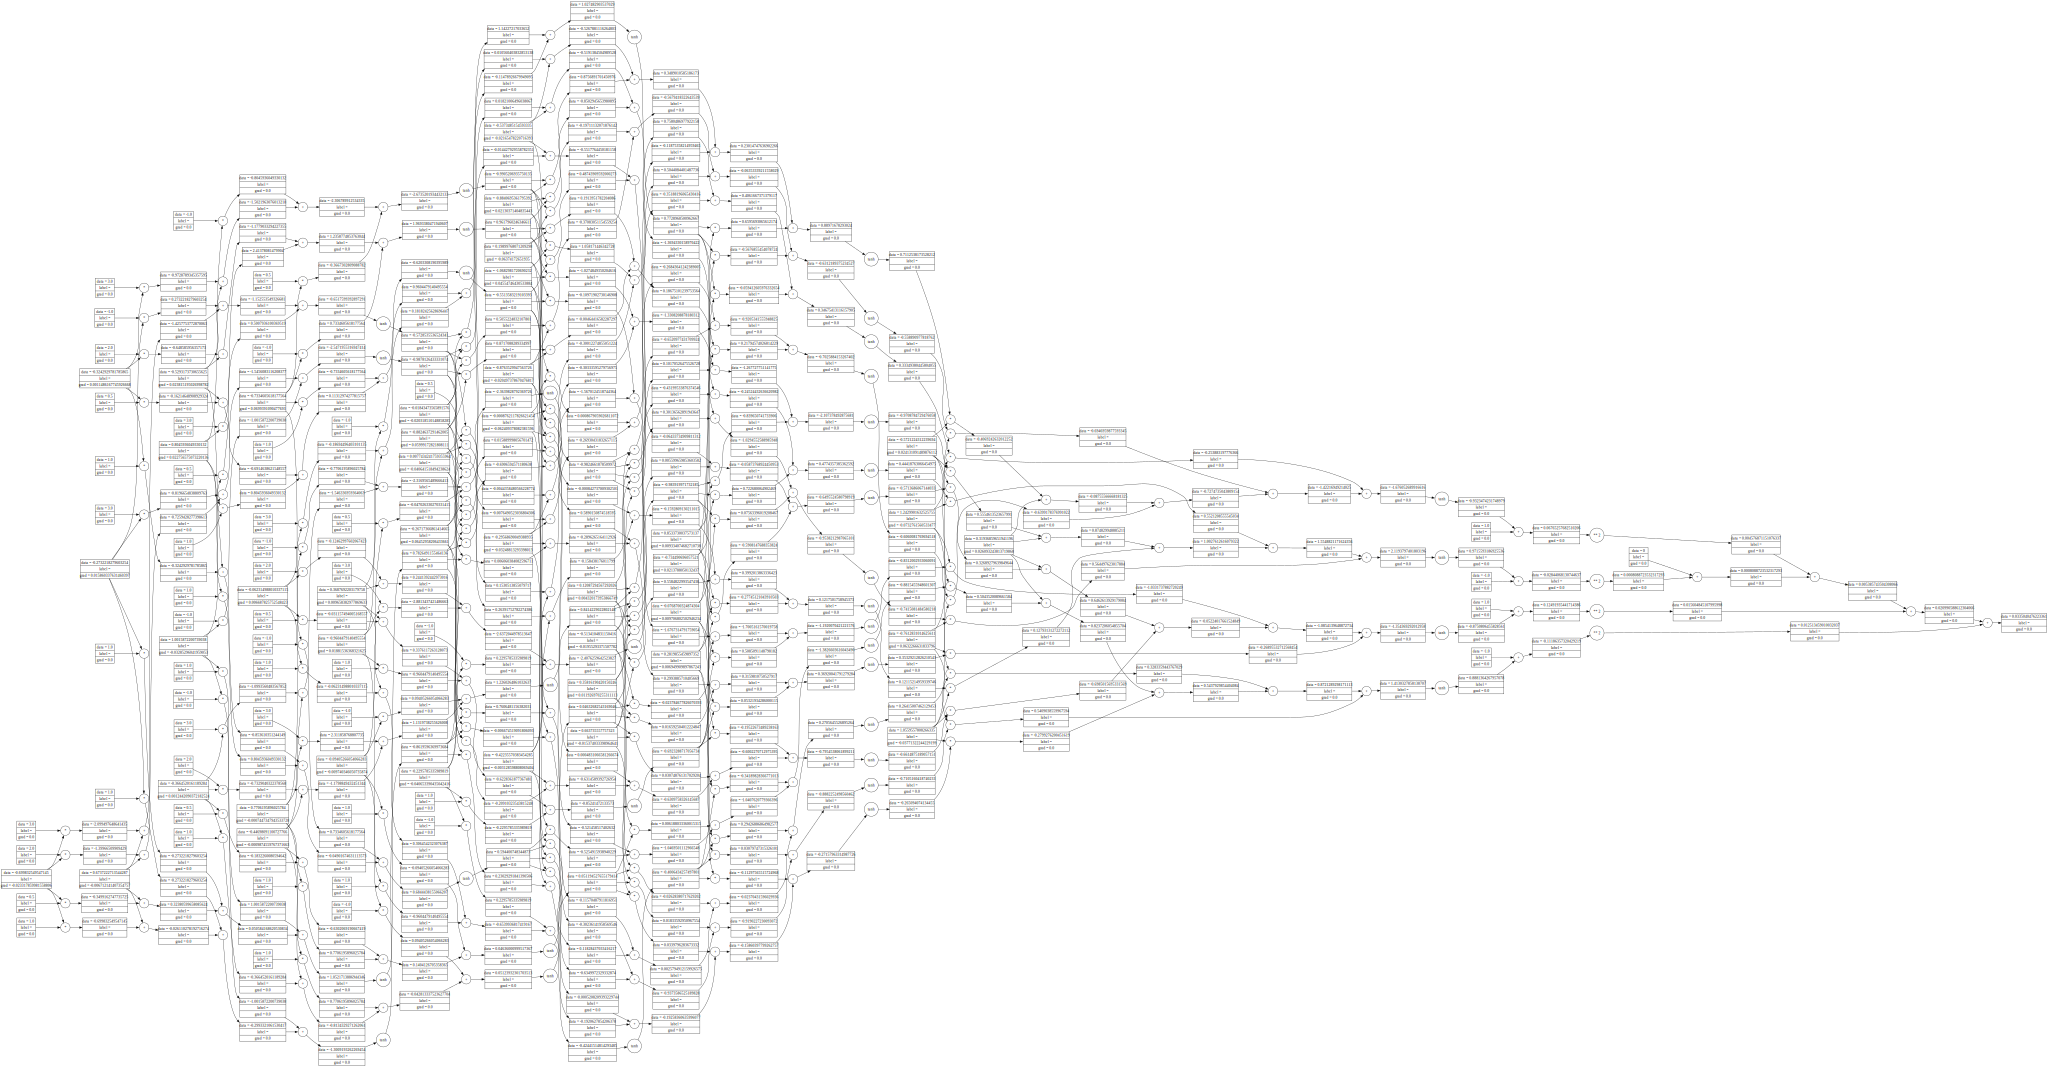

In [48]:
dot